In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [2]:
arq_portabilidade = "C:\\Users\\Cliente\\OneDrive\\Documentos\\ic_telecom\\anatel\\portabilidade\\CSV_PORTABILIDADE.csv"
arq_saldo = "C:\\Users\\Cliente\\OneDrive\\Documentos\\ic_telecom\\anatel\\portabilidade\\CSV_SALDO.csv"

In [3]:
df_portabilidade = pd.read_csv(arq_portabilidade, sep=';')
df_saldo = pd.read_csv(arq_saldo, sep=';')

In [4]:
# visualizacao de dados
df_portabilidade.head()

,NU_CNPJ_DOADORA,NO_PRESTADORA_DOADORA,NU_CNPJ_RECEPTORA,NO_PRESTADORA_RECEPTORA,AA_EFETIVACAO,MM_EFETIVACAO,AM_EFETIVACAO,DT_EFETIVACAO,NU_SERVICO,SG_SERVICO,CO_CN,SG_UF,QT_PORTABILIDADE_EFETIVADA
0,76535764000143,OI S.A.,2558157000162,TELEFONICA BRASIL,2008,9,2008-09,01/09/2008,171,STFC,43,PR,365
1,76535764000143,OI S.A.,2558157000162,TELEFONICA BRASIL,2008,9,2008-09,01/09/2008,171,STFC,62,GO,1019
2,76535764000143,OI S.A.,2558157000162,TELEFONICA BRASIL,2008,9,2008-09,01/09/2008,171,STFC,67,MS,564
3,76535764000143,OI S.A.,2558157000162,TELEFONICA BRASIL,2008,12,2008-12,01/12/2008,171,STFC,43,PR,391
4,76535764000143,OI S.A.,2558157000162,TELEFONICA BRASIL,2008,12,2008-12,01/12/2008,171,STFC,44,PR,1478


In [5]:
# visualizacao de dados 
df_saldo.head()

,NU_CNPJ,NO_PRESTADORA,ID_DT_EFETIVACAO,DT_EFETIVACAO,AA_FORMATADA,MM_FORMATADA,AM_FORMATADA,NU_SERVICO,SG_SERVICO,CO_CN,SG_UF,NO_UF,QT_PORTABILIDADE_DOADO,QT_PORTABILIDADE_RECEBIDO,QT_SALDO
0,40432544000147,CLARO S.A.,20230401,01/04/2023,2023,4,2023-04,10,SMP,67,MS,Mato Grosso do Sul,1566,2356,790
1,2421421000111,TIM S A,20150601,01/06/2015,2015,6,2015-06,10,SMP,77,BA,Bahia,23,6,-17
2,76535764000143,OI S.A. - EM RECUPERACAO JUDICIAL,20110201,01/02/2011,2011,2,2011-02,10,SMP,68,AC,Acre,67,79,12
3,1371416000189,SERCOMTEL S/A TELECOMUNICACOES,20111201,01/12/2011,2011,12,2011-12,10,SMP,43,PR,Paraná,221,58,-163
4,11208525000133,LIGUE TELECOM SERVICOS LTDA,20141001,01/10/2014,2014,10,2014-10,171,STFC,44,PR,Paraná,32,36,4


In [6]:
# retirando dos df's informacoes desnecessarias
df_portabilidade.drop(columns=['NU_CNPJ_DOADORA','NU_CNPJ_RECEPTORA','NU_SERVICO', 'CO_CN','AM_EFETIVACAO'], inplace=True)

df_saldo.drop(columns=['NO_UF','CO_CN','NU_SERVICO','AM_FORMATADA','ID_DT_EFETIVACAO','NU_CNPJ'], inplace=True)

In [7]:
# transformando as colunas de datas no tipo datetime64

df_portabilidade['DT_EFETIVACAO'] = pd.to_datetime(df_portabilidade['DT_EFETIVACAO'], format='%d/%m/%Y')
df_saldo['DT_EFETIVACAO'] = pd.to_datetime(df_saldo['DT_EFETIVACAO'], format='%d/%m/%Y')

In [8]:
# verificando se os tipos estão adequados
df_portabilidade.info()
print('\n')
df_saldo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593247 entries, 0 to 593246
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   NO_PRESTADORA_DOADORA       593247 non-null  object        
 1   NO_PRESTADORA_RECEPTORA     593247 non-null  object        
 2   AA_EFETIVACAO               593247 non-null  int64         
 3   MM_EFETIVACAO               593247 non-null  int64         
 4   DT_EFETIVACAO               593247 non-null  datetime64[ns]
 5   SG_SERVICO                  593247 non-null  object        
 6   SG_UF                       593247 non-null  object        
 7   QT_PORTABILIDADE_EFETIVADA  593247 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 36.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148986 entries, 0 to 148985
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype    

In [9]:
import re

# Função para substituir NEXTEL e CLARO
def substituir_operadoras(texto):
    if isinstance(texto, str):
        texto = texto.upper()
        if 'NEXTEL' in texto:
            return 'CLARO S.A.'
        elif 'CLARO' in texto and 'CLARO S.A.' not in texto:
            return 'CLARO S.A.'
    return texto

# Aplicar a função a todas as colunas relevantes
df_portabilidade['NO_PRESTADORA_DOADORA'] = df_portabilidade['NO_PRESTADORA_DOADORA'].apply(substituir_operadoras)
df_portabilidade['NO_PRESTADORA_RECEPTORA'] = df_portabilidade['NO_PRESTADORA_RECEPTORA'].apply(substituir_operadoras)
df_saldo['NO_PRESTADORA'] = df_saldo['NO_PRESTADORA'].apply(substituir_operadoras)

In [10]:
# renomeando colunas para uma melhor visualizacao

df_portabilidade.rename(columns={
    "NO_PRESTADORA_DOADORA": "DOADORA",
    "NO_PRESTADORA_RECEPTORA": "RECEPTORA",
    "AA_EFETIVACAO": "ANO",
    "MM_EFETIVACAO": "MES"
}, inplace=True)

df_saldo.rename(columns={
    "NO_PRESTADORA": "PRESTADORA",
    "AA_FORMATADA": "ANO",
    "MM_FORMATADA": "MES",
    "QT_PORTABILIDADE_DOADO": "PORT_DOADO",
    "QT_PORTABILIDADE_RECEBIDO": "PORT_RECEBIDO",
    "QT_SALDO": "SALDO"
}, inplace=True)

## Data frames com os dados trabalhados

In [11]:
df_portabilidade.head()

,DOADORA,RECEPTORA,ANO,MES,DT_EFETIVACAO,SG_SERVICO,SG_UF,QT_PORTABILIDADE_EFETIVADA
0,OI S.A.,TELEFONICA BRASIL,2008,9,2008-09-01,STFC,PR,365
1,OI S.A.,TELEFONICA BRASIL,2008,9,2008-09-01,STFC,GO,1019
2,OI S.A.,TELEFONICA BRASIL,2008,9,2008-09-01,STFC,MS,564
3,OI S.A.,TELEFONICA BRASIL,2008,12,2008-12-01,STFC,PR,391
4,OI S.A.,TELEFONICA BRASIL,2008,12,2008-12-01,STFC,PR,1478


In [12]:
df_saldo.head()

,PRESTADORA,DT_EFETIVACAO,ANO,MES,SG_SERVICO,SG_UF,PORT_DOADO,PORT_RECEBIDO,SALDO
0,CLARO S.A.,2023-04-01,2023,4,SMP,MS,1566,2356,790
1,TIM S A,2015-06-01,2015,6,SMP,BA,23,6,-17
2,OI S.A. - EM RECUPERACAO JUDICIAL,2011-02-01,2011,2,SMP,AC,67,79,12
3,SERCOMTEL S/A TELECOMUNICACOES,2011-12-01,2011,12,SMP,PR,221,58,-163
4,LIGUE TELECOM SERVICOS LTDA,2014-10-01,2014,10,STFC,PR,32,36,4


## Análise exploratoria de dados
1. Operadoras que mais recebem
2. Operadoras que mais perdem
3. Analise de saldos
5. Analise entre maiores relacoes de trocas entre operadores (heatmap com as 5 maiores)
6. volume de portabilidade por estado
7. Portabilidade por tipo de servico

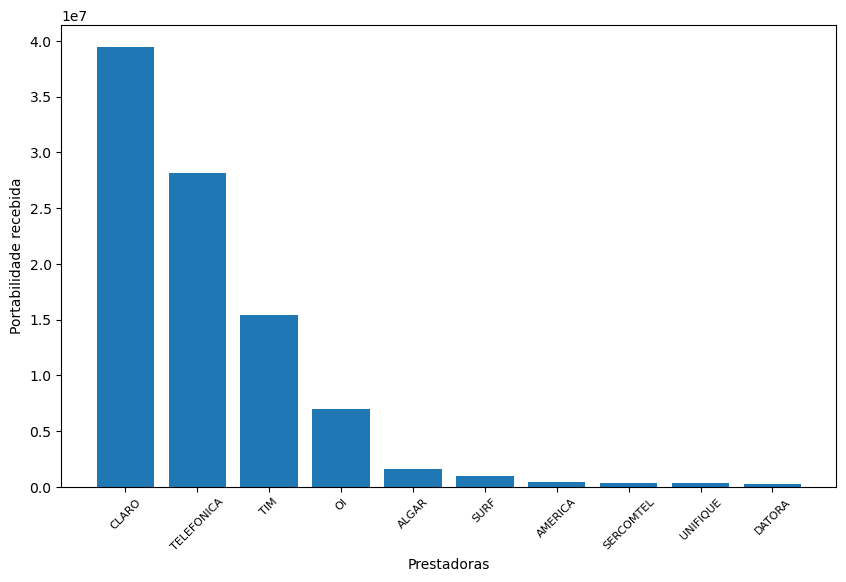

In [13]:
# somando a quantidade de clientes recebidos
agg_receptores = df_saldo[['PRESTADORA', 'PORT_RECEBIDO']].groupby(['PRESTADORA']).sum().reset_index()

maiores_receptores = agg_receptores.sort_values(
    by='PORT_RECEBIDO',
    ascending=False,
    axis=0,
).head(10).reset_index(drop=True)

# reduzindo os nomes para melhor exibicao no grafico
maiores_receptores['PRESTADORA'] = maiores_receptores['PRESTADORA'].astype(str).str.split().str[0]

# criando o grafico para analise
x = maiores_receptores['PRESTADORA']
y = maiores_receptores['PORT_RECEBIDO']

plt.figure(figsize=(10,6))
plt.bar(x,y)
plt.xlabel('Prestadoras')
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('Portabilidade recebida')
plt.show()



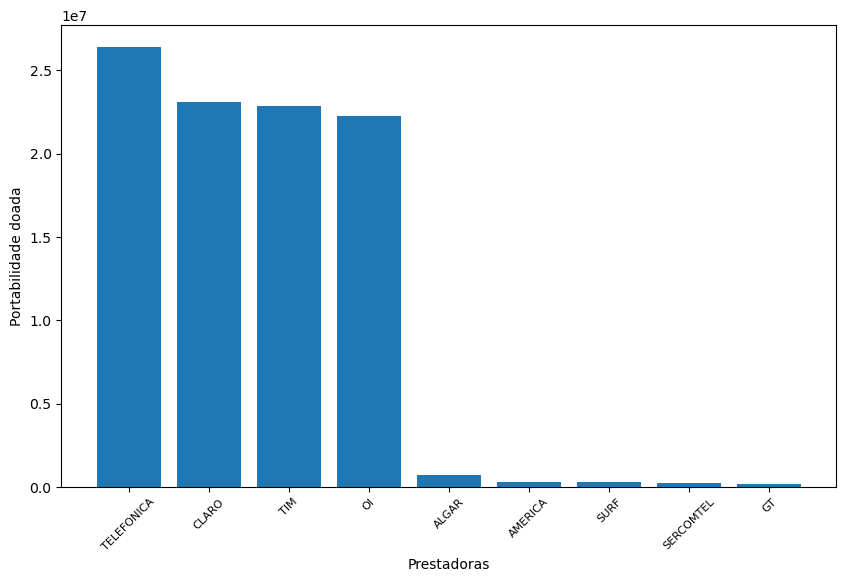

In [14]:
# somando a quantidade de clientes doados
agg_doadores = df_saldo[['PRESTADORA', 'PORT_DOADO']].groupby(['PRESTADORA']).sum().reset_index()

maiores_doadores = agg_doadores.sort_values(
    by='PORT_DOADO',
    ascending=False,
    axis=0,
).head(10).reset_index(drop=True)

# adequando os nomes
maiores_doadores['PRESTADORA'] = maiores_doadores['PRESTADORA'].astype(str).str.split().str[0]

#criando o grafico
x = maiores_doadores['PRESTADORA']
y = maiores_doadores['PORT_DOADO']

plt.figure(figsize=(10,6))
plt.bar(x,y)
plt.xlabel('Prestadoras')
plt.ylabel('Portabilidade doada')
plt.xticks(fontsize=8, rotation=45)
plt.show()

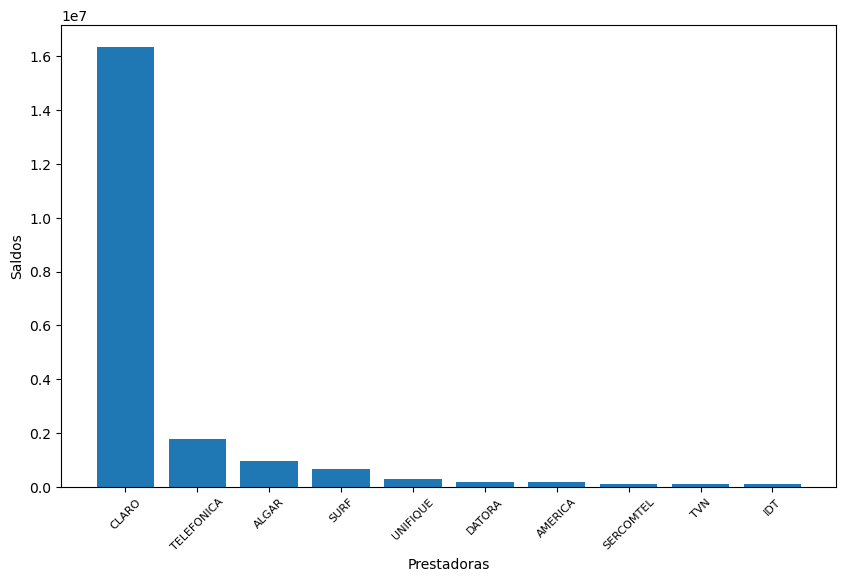

In [15]:
# analisando os saldos
agg_saldo = df_saldo[['PRESTADORA','SALDO']].groupby(['PRESTADORA']).sum().reset_index()

# filtrando apenas os 10 maiores
maiores_saldos = agg_saldo.sort_values(by='SALDO', ascending=False, axis=0).head(10).reset_index(drop=True)

# ajuste de tamanho de nome
maiores_saldos['PRESTADORA'] = maiores_saldos['PRESTADORA'].astype(str).str.split().str[0]

# criando o grafico
x = maiores_saldos['PRESTADORA']
y = maiores_saldos['SALDO']

plt.figure(figsize=(10,6))
plt.bar(x,y)
plt.xlabel('Prestadoras')
plt.ylabel('Saldos')
plt.xticks(fontsize=8, rotation=45)
plt.show()

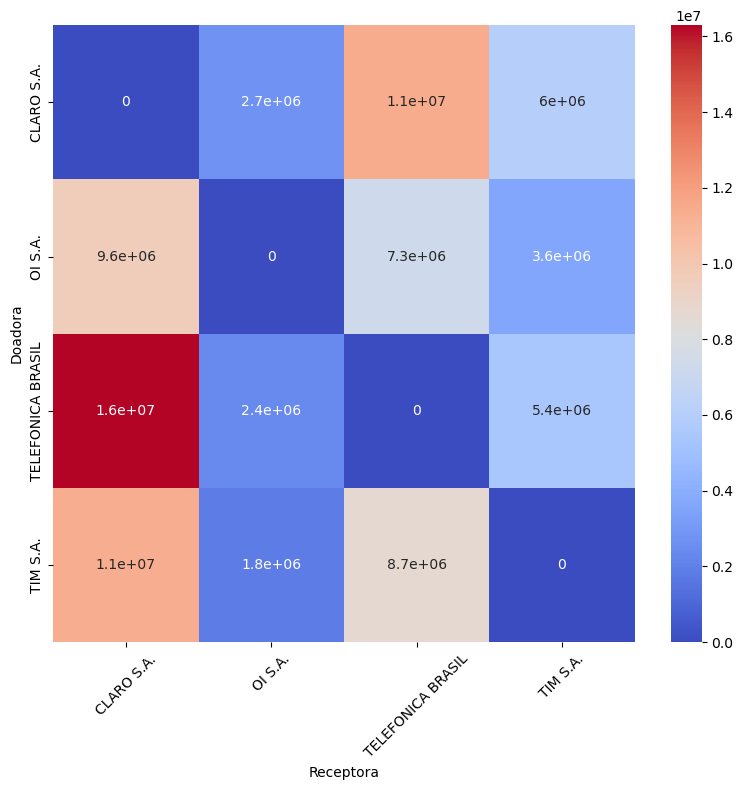

In [16]:
# trabalhando as relacoes entre operadoras

agg_trocas = df_portabilidade.groupby(['DOADORA', 'RECEPTORA'])['QT_PORTABILIDADE_EFETIVADA'].sum().reset_index()
maiores_canais = agg_trocas.sort_values(by='QT_PORTABILIDADE_EFETIVADA',axis=0,ascending=False).head(12).reset_index(drop=True)

heatmap_data = maiores_canais.pivot(index='DOADORA', columns='RECEPTORA', values='QT_PORTABILIDADE_EFETIVADA').fillna(0)

# criando o heatmap
plt.figure(figsize=(8,8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="coolwarm"
)
plt.xlabel('Receptora')
plt.ylabel('Doadora')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

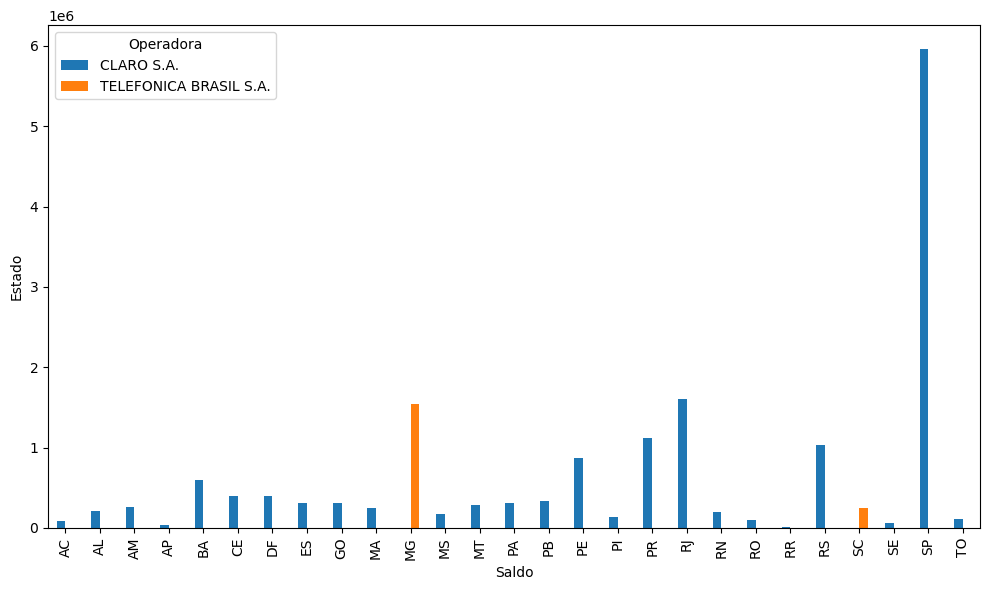

In [17]:
# analisando por estado
saldo_por_estado = df_saldo.groupby(['SG_UF', 'PRESTADORA'])['SALDO'].sum().reset_index()
saldo_por_estado = saldo_por_estado.sort_values(ascending=False, by=['SG_UF','SALDO'])
saldo_por_estado = saldo_por_estado.drop_duplicates('SG_UF').reset_index()

# preparando os dados para o grafico
estado_pivotado = saldo_por_estado.pivot(index='SG_UF', columns='PRESTADORA', values='SALDO')

# criando o grafico
estado_pivotado.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.xlabel('Saldo')
plt.ylabel('Estado')
plt.legend(title='Operadora')
plt.tight_layout()
plt.show()

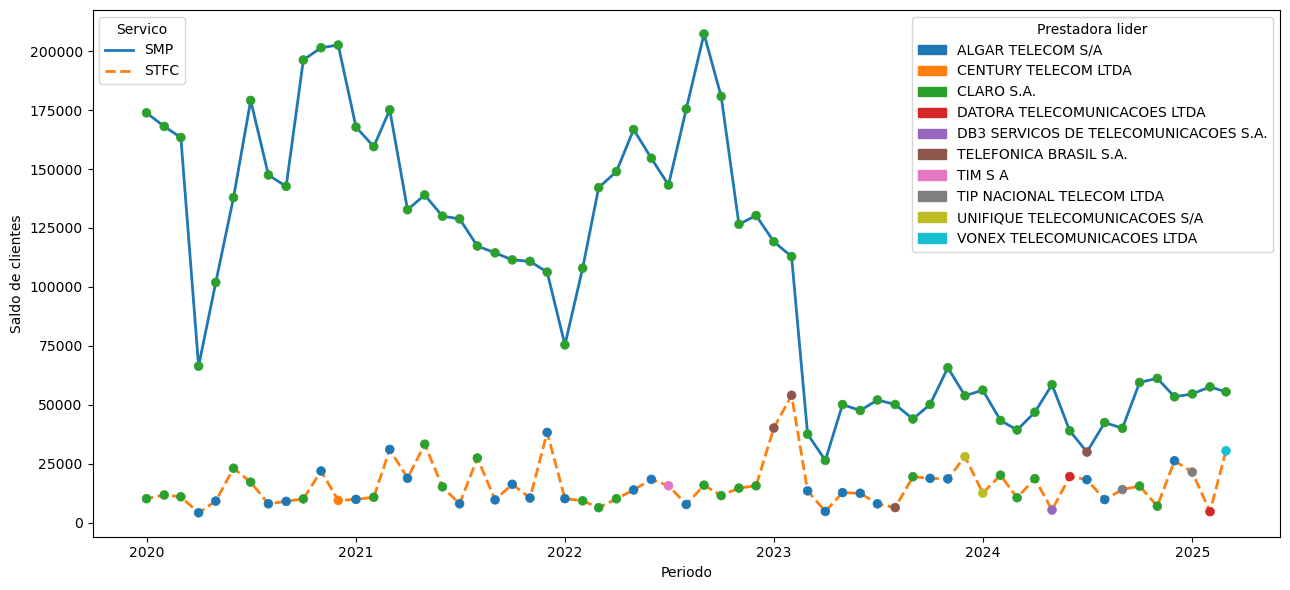

In [18]:

# agrupando os dados necessarios
    # por tipo de serviço, prestadora, e por mes

agg_tipo_servico = df_saldo.groupby(['SG_SERVICO','PRESTADORA','ANO','MES'])['SALDO'].sum().reset_index()
agg_tipo_servico = agg_tipo_servico.sort_values(by=['SG_SERVICO','ANO','MES','SALDO'], ascending=False)

# adequando a ordem dos eixos para a analise
tipo_servico_temporal = agg_tipo_servico.drop_duplicates(['SG_SERVICO','ANO','MES']).reset_index()
tipo_servico_temporal = tipo_servico_temporal.sort_values(by=['ANO','MES','SALDO'], ascending=False)

# filtrando para datas a partir de 2020 para nao ter excesso de dados
tipo_servico_temporal = tipo_servico_temporal[tipo_servico_temporal['ANO'] >= 2020]
tipo_servico_temporal.drop(columns=['index'], inplace=True)

# criando uma coluna datetime para anaslise temporal
tipo_servico_temporal['DATA'] = pd.to_datetime(dict(
    year=tipo_servico_temporal.ANO,
    month=tipo_servico_temporal.MES,
    day=1
))

# paleta de cores para prestadoras
prestadoras = sorted(tipo_servico_temporal['PRESTADORA'].unique())
cmap = plt.get_cmap("tab10")
color_dict = {p: cmap(i % 10) for i, p in enumerate(prestadoras)}


# plotando 
fig, ax = plt.subplots(figsize=(13,6))

estilos = {
    "SMP": "-",
    "STFC": "--"
    }

for servico in ["SMP", "STFC"]:
    sub = tipo_servico_temporal[tipo_servico_temporal['SG_SERVICO'] == servico]
    if sub.empty:
        continue
    # linhas continuas
    ax.plot(sub['DATA'], sub['SALDO'],
            linestyle=estilos.get(servico, "-"),
            linewidth=2,
            label=servico)

    # pontos das operadoras
    ax.scatter(
        sub['DATA'],
        sub['SALDO'],
        s = 40,
        linewidth=0.5,
        c=[color_dict[p] for p in sub['PRESTADORA']],
        zorder=3
    )
# criacao das legendas
leg_serv = ax.legend(title="Servico", loc="upper left")

handle_prestadoras = [mpatches.Patch(color=color_dict[p], label=p) for p in prestadoras]
leg_prestadoras = ax.legend(handles=handle_prestadoras, title="Prestadora lider", loc="upper right")

ax.add_artist(leg_serv)

# formatacao final
ax.set_xlabel("Periodo")
ax.set_ylabel("Saldo de clientes")
plt.tight_layout()
plt.show()

In [19]:
# grafico por regiao
regioes = {
    'AC':'N',
    'AM':'N',
    'RO':'N',
    'RR':'N',
    'PA':'N',
    'AP':'N',
    'TO':'N',
    'MA':'NE',
    'PI':'NE',
    'CE':'NE',
    'BA':'NE',
    'RN':'NE',
    'PB':'NE',
    'PE':'NE',
    'AL':'NE',
    'SE':'NE',
    'DF':'CO',
    'GO':'CO',
    'MT':'CO',
    'MS':'CO',
    'MG':'SE',
    'ES':'SE',
    'RJ':'SE',
    'SP':'SE',
    'PR':'S',
    'SC':'S',
    'RS':'S'
}

# criando os novos dataframes por regiao
anls_regiao = df_saldo.copy()

anls_regiao['REGIAO'] = anls_regiao['SG_UF'].map(regioes)

dfs_por_regiao = {
    regiao: df_regiao for regiao, df_regiao in anls_regiao.groupby('REGIAO')
}

df_norte = dfs_por_regiao['N']
df_nordeste = dfs_por_regiao['NE']
df_centro_oeste = dfs_por_regiao['CO']
df_sudeste = dfs_por_regiao['SE']
df_sul = dfs_por_regiao['S']



In [20]:
def plot_servico_temporal(df_regiao, nome_regiao):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import pandas as pd

    # agrupando os dados necessários
    agg_tipo_servico = df_regiao.groupby(['SG_SERVICO','PRESTADORA','ANO','MES'])['SALDO'].sum().reset_index()
    agg_tipo_servico = agg_tipo_servico.sort_values(by=['SG_SERVICO','ANO','MES','SALDO'], ascending=False)

    # adequando a ordem dos eixos para a análise
    tipo_servico_temporal = agg_tipo_servico.drop_duplicates(['SG_SERVICO','ANO','MES']).reset_index(drop=True)
    tipo_servico_temporal = tipo_servico_temporal.sort_values(by=['ANO','MES','SALDO'], ascending=False)

    # filtrando para datas a partir de 2020
    tipo_servico_temporal = tipo_servico_temporal[tipo_servico_temporal['ANO'] >= 2020]

    # criando coluna datetime
    tipo_servico_temporal['DATA'] = pd.to_datetime(dict(
        year=tipo_servico_temporal.ANO,
        month=tipo_servico_temporal.MES,
        day=1
    ))

    # paleta de cores por prestadora
    prestadoras = sorted(tipo_servico_temporal['PRESTADORA'].unique())
    cmap = plt.get_cmap("tab20")
    color_dict = {p: cmap(i % 20) for i, p in enumerate(prestadoras)}

    # mantendo tamanho original
    fig, ax = plt.subplots(figsize=(13, 9))
    estilos = {"SMP": "-", "STFC": "--"}

    for servico in ["SMP", "STFC"]:
        sub = tipo_servico_temporal[tipo_servico_temporal['SG_SERVICO'] == servico]
        if sub.empty:
            continue
        ax.plot(sub['DATA'], sub['SALDO'],
                linestyle=estilos.get(servico, "-"),
                linewidth=2,
                label=servico)
        ax.scatter(
            sub['DATA'],
            sub['SALDO'],
            s=40,
            linewidth=0.5,
            c=[color_dict[p] for p in sub['PRESTADORA']],
            zorder=3
        )

    # legenda de serviços (SMP/STFC) no canto superior esquerdo
    leg_serv = ax.legend(title="Serviço", loc="upper left")
    ax.add_artist(leg_serv)

    # legenda das prestadoras na parte inferior, com várias colunas
    handle_prestadoras = [mpatches.Patch(color=color_dict[p], label=p) for p in prestadoras]
    ax.legend(
        handles=handle_prestadoras,
        title="Prestadora líder",
        bbox_to_anchor=(0.5, -0.25),
        loc='upper center',
        ncol=4,
        fontsize='small',
        frameon=False
    )

    # formatação final
    ax.set_xlabel("Período")
    ax.set_ylabel("Saldo de clientes")
    plt.tight_layout(rect=[0, 0.2, 1, 1])  # espaço para a legenda inferior
    
    plt.show()


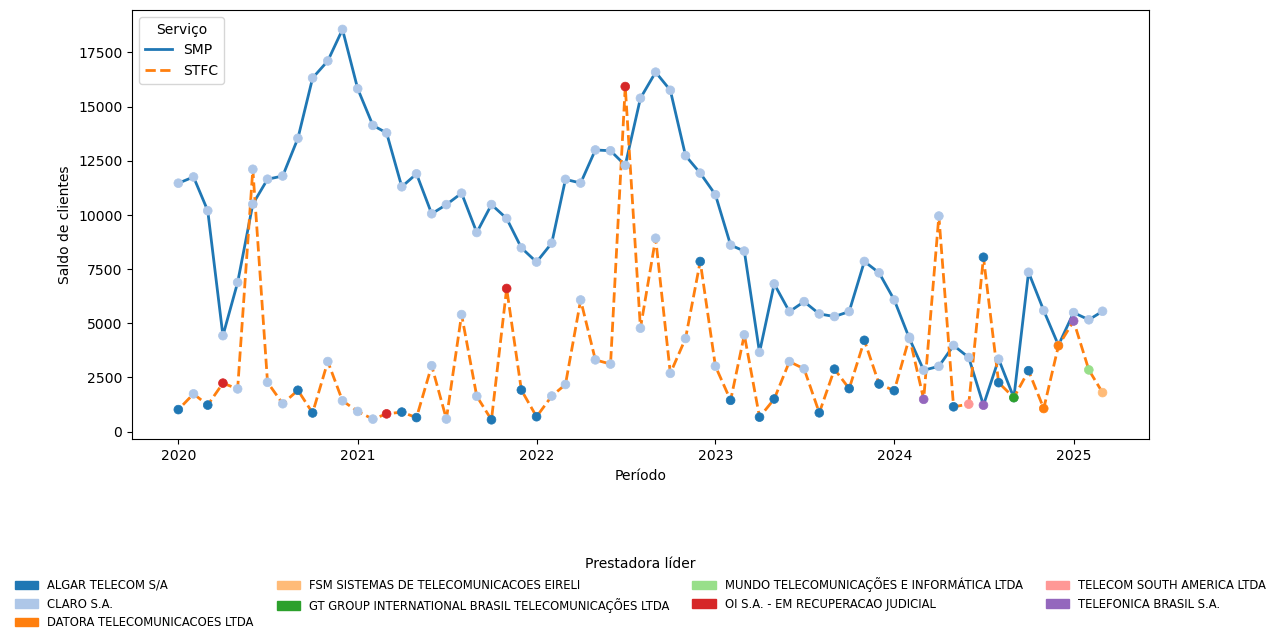

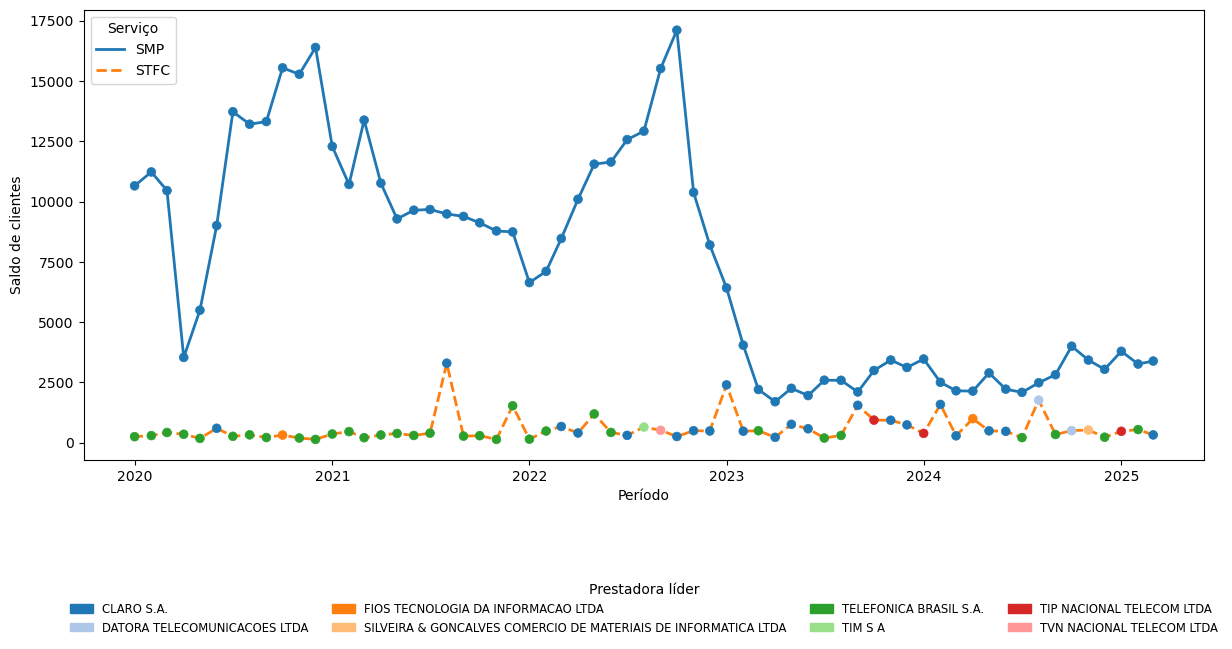

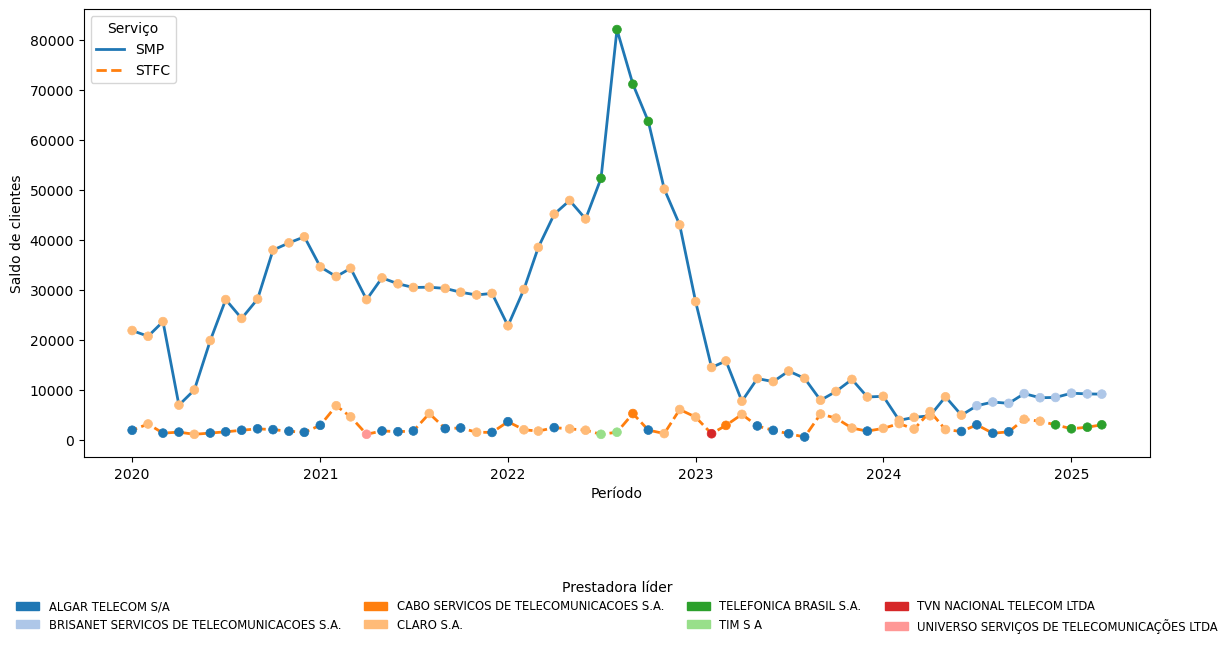

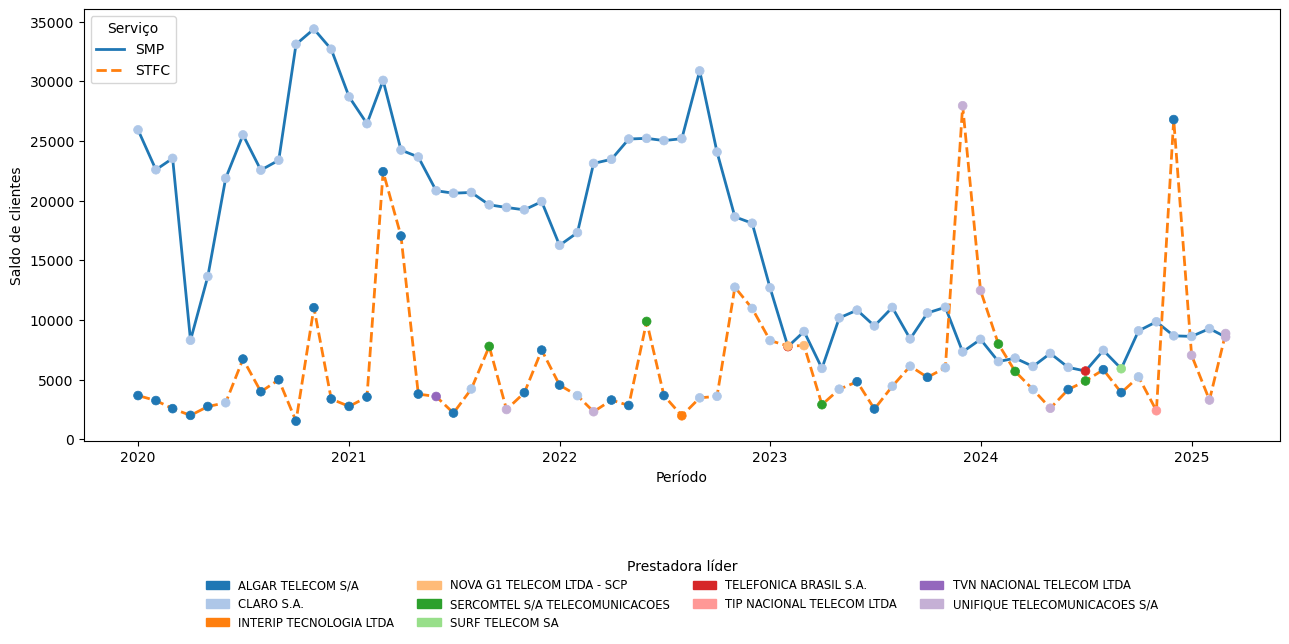

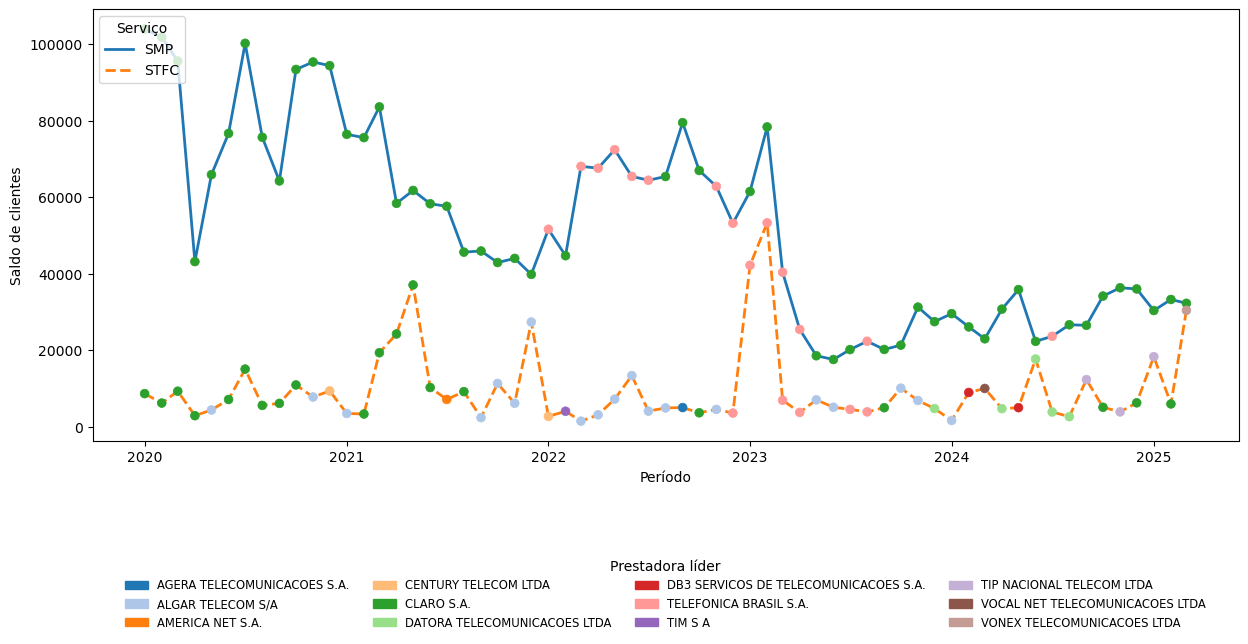

In [21]:
for regiao_nome, df_reg in dfs_por_regiao.items():
    plot_servico_temporal(df_reg, regiao_nome)

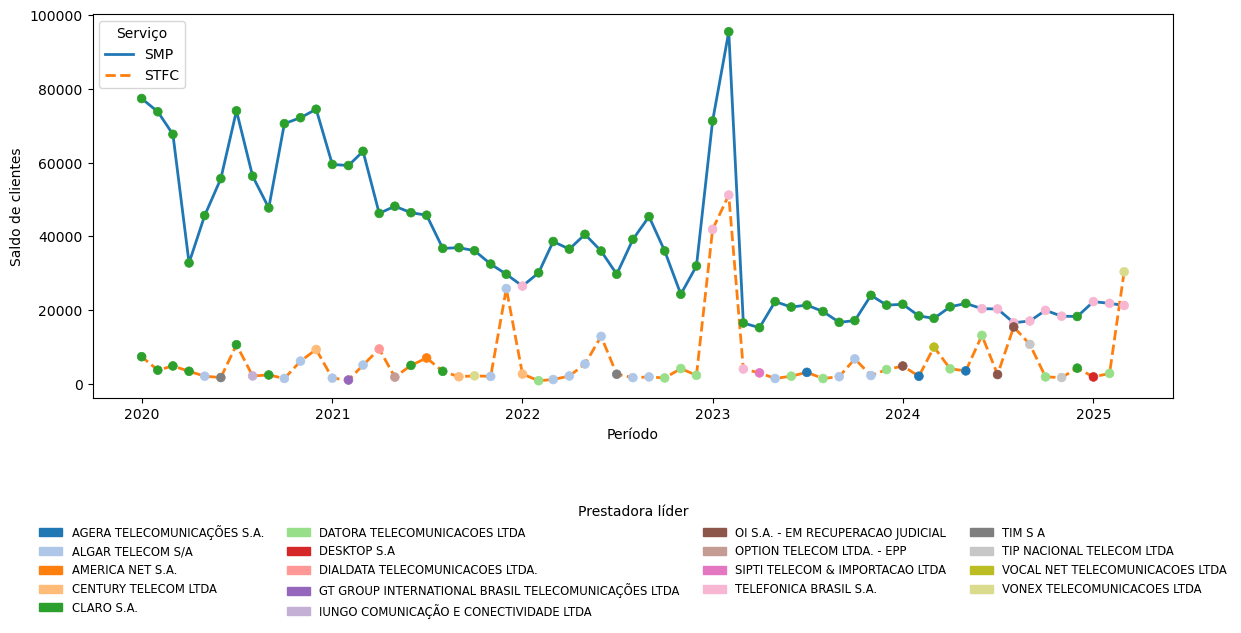

In [22]:
# criando a mesma analise para SP
anls_sp = anls_regiao[anls_regiao['SG_UF'] == 'SP']
agg_tipo_servico = anls_sp.groupby(['SG_SERVICO', 'PRESTADORA', 'ANO', 'MES'])['SALDO'].sum().reset_index()
agg_tipo_servico = agg_tipo_servico.sort_values(by=['SG_SERVICO', 'ANO', 'MES', 'SALDO'], ascending=False)

# adequando a ordem dos eixos para a análise
tipo_servico_temporal = agg_tipo_servico.drop_duplicates(['SG_SERVICO', 'ANO', 'MES']).reset_index(drop=True)
tipo_servico_temporal = tipo_servico_temporal.sort_values(by=['ANO', 'MES', 'SALDO'], ascending=False)

# filtrando para datas a partir de 2020
tipo_servico_temporal = tipo_servico_temporal[tipo_servico_temporal['ANO'] >= 2020]

# criando coluna datetime
tipo_servico_temporal['DATA'] = pd.to_datetime(dict(
    year=tipo_servico_temporal.ANO,
    month=tipo_servico_temporal.MES,
    day=1
))

# paleta de cores por prestadora
prestadoras = sorted(tipo_servico_temporal['PRESTADORA'].unique())
cmap = plt.get_cmap("tab20")
color_dict = {p: cmap(i % 20) for i, p in enumerate(prestadoras)}

# plotando
fig, ax = plt.subplots(figsize=(13, 9))

estilos = {
    "SMP": "-",
    "STFC": "--"
}

for servico in ["SMP", "STFC"]:
    sub = tipo_servico_temporal[tipo_servico_temporal['SG_SERVICO'] == servico]
    if sub.empty:
        continue

    ax.plot(sub['DATA'], sub['SALDO'],
            linestyle=estilos.get(servico, "-"),
            linewidth=2,
            label=servico)

    ax.scatter(
        sub['DATA'],
        sub['SALDO'],
        s=40,
        linewidth=0.5,
        c=[color_dict[p] for p in sub['PRESTADORA']],
        zorder=3
    )

# legenda dos serviços
leg_serv = ax.legend(title="Serviço", loc="upper left")
ax.add_artist(leg_serv)

# legenda das prestadoras na parte inferior
handle_prestadoras = [mpatches.Patch(color=color_dict[p], label=p) for p in prestadoras]
ax.legend(
    handles=handle_prestadoras,
    title="Prestadora líder",
    bbox_to_anchor=(0.5, -0.25),
    loc='upper center',
    ncol=4,
    fontsize='small',
    frameon=False
)

# ajustes finais
ax.set_xlabel("Período")
ax.set_ylabel("Saldo de clientes")
plt.tight_layout(rect=[0, 0.2, 1, 1])  # espaço extra abaixo para a legenda
plt.savefig('sao_paulo.png', dpi=300, bbox_inches='tight')
plt.show()


## Preparacao para o modelo regressor
Realizando agora os encondings necessarios

In [23]:
ohe = OneHotEncoder(drop="first", sparse_output=False)

# fazendo o onehot encoding dos tipos de servico
ohe.fit(df_saldo[['SG_SERVICO']])
SERVICO_encoded = ohe.transform(df_saldo[['SG_SERVICO']])
SERVICO_encoded_df = pd.DataFrame(SERVICO_encoded, columns=ohe.get_feature_names_out(['SG_SERVICO']))
df_saldo = pd.concat([df_saldo.drop(columns=['SG_SERVICO']), SERVICO_encoded_df], axis=1)

In [24]:
ohe.fit(df_portabilidade[['SG_SERVICO']])
SERVICO_enconded_port = ohe.transform(df_portabilidade[['SG_SERVICO']])
SERVICO_enconded_port_df = pd.DataFrame(SERVICO_enconded_port, columns=ohe.get_feature_names_out(['SG_SERVICO']))
df_portabilidade = pd.concat([df_portabilidade.drop(columns=['SG_SERVICO']), SERVICO_enconded_port_df], axis=1)

In [25]:
l_enconder = LabelEncoder()
# realizando o enconding das colunas do df_saldo

df_saldo['PRESTADORA_enconded'] = l_enconder.fit_transform(df_saldo['PRESTADORA'])
df_saldo['SG_UF_enconded'] = l_enconder.fit_transform(df_saldo['SG_UF'])

# guardando em um dataframe os encodings 
mapeamento_prestadoras = df_saldo[['PRESTADORA', 'PRESTADORA_enconded']].drop_duplicates().sort_values(by='PRESTADORA', ascending=True)
mapeamento_uf_saldo = df_saldo[['SG_UF', 'SG_UF_enconded']].drop_duplicates().sort_values(by='SG_UF', ascending=True)

# excluindo as antigas colunas, agora obsoletas
df_saldo.drop(columns=['PRESTADORA', 'SG_UF'], inplace=True)

In [26]:
# enconding df_portabilidade
df_portabilidade['DOADORA_encoded'] = l_enconder.fit_transform(df_portabilidade['DOADORA'])
df_portabilidade['RECEPTORA_encoded'] = l_enconder.fit_transform(df_portabilidade['RECEPTORA'])
df_portabilidade['SG_UF_encoded'] = l_enconder.fit_transform(df_portabilidade['SG_UF'])

# mapeando os dados 
mapeamento_doadoras = df_portabilidade[['DOADORA', 'DOADORA_encoded']].drop_duplicates().sort_values(by='DOADORA', ascending=True)
mapeamento_receptoras = df_portabilidade[['RECEPTORA', 'RECEPTORA_encoded']].drop_duplicates().sort_values(by='RECEPTORA', ascending=True)
mapeamento_uf_port = df_portabilidade[['SG_UF', 'SG_UF_encoded']].drop_duplicates().sort_values(by='SG_UF', ascending=True)

# deletrnado colunas sem o encoding
df_portabilidade.drop(columns=['DOADORA', 'RECEPTORA', 'SG_UF'], inplace=True)

In [27]:
# revendo os dataframes
print("df_portabilidade")
display(df_portabilidade.head())
print("\ndf_saldo")
display(df_saldo.head())

df_portabilidade


,ANO,MES,DT_EFETIVACAO,QT_PORTABILIDADE_EFETIVADA,SG_SERVICO_STFC,DOADORA_encoded,RECEPTORA_encoded,SG_UF_encoded
0,2008,9,2008-09-01,365,1.0,241,373,17
1,2008,9,2008-09-01,1019,1.0,241,373,8
2,2008,9,2008-09-01,564,1.0,241,373,11
3,2008,12,2008-12-01,391,1.0,241,373,17
4,2008,12,2008-12-01,1478,1.0,241,373,17



df_saldo


,DT_EFETIVACAO,ANO,MES,PORT_DOADO,PORT_RECEBIDO,SALDO,SG_SERVICO_STFC,PRESTADORA_enconded,SG_UF_enconded
0,2023-04-01,2023,4,1566,2356,790,0.0,66,11
1,2015-06-01,2015,6,23,6,-17,0.0,341,4
2,2011-02-01,2011,2,67,79,12,0.0,242,0
3,2011-12-01,2011,12,221,58,-163,0.0,297,17
4,2014-10-01,2014,10,32,36,4,1.0,188,17


## Analise de correlacao entre atributos


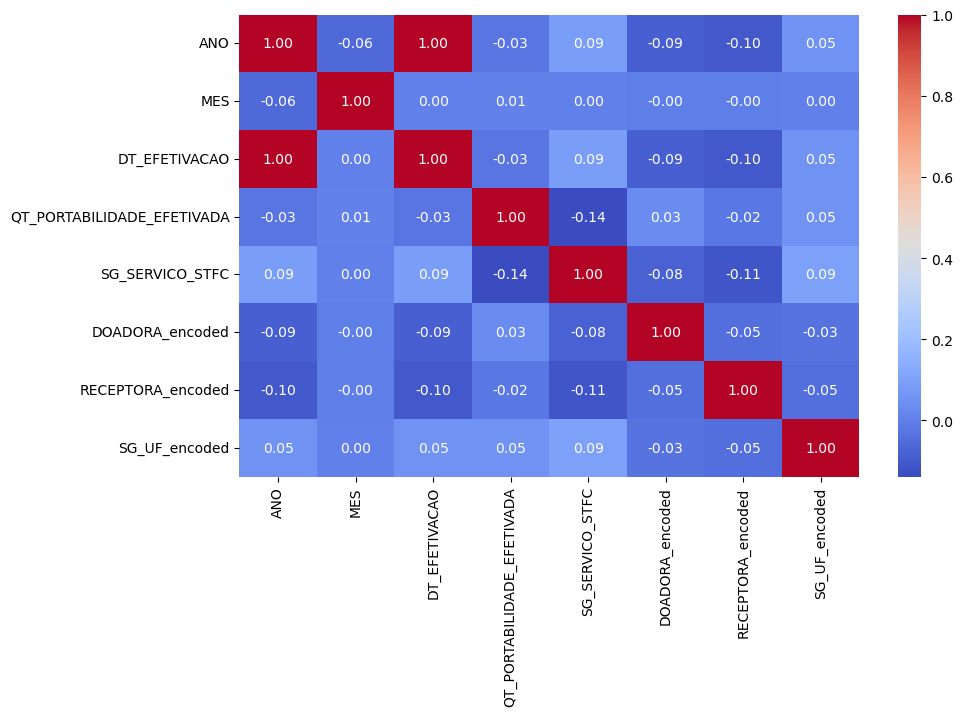

In [28]:
# correlacao do df_portabilidade
corr = df_portabilidade.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.savefig('corr_port.png', dpi=300, bbox_inches='tight')
plt.show()

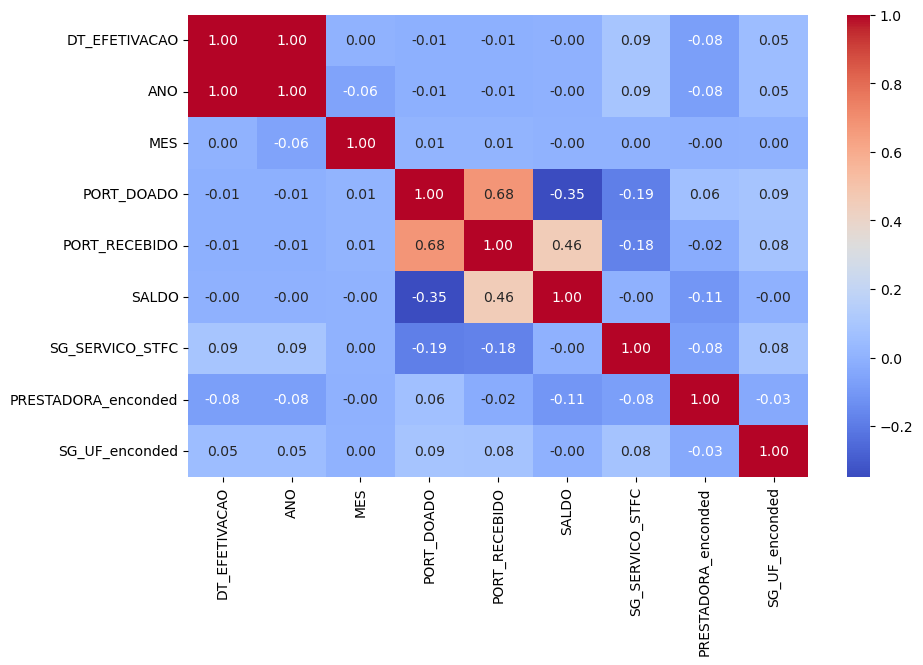

In [29]:
# correlacao do df_saldo
corr = df_saldo.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.savefig('corr_saldo.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
features = ['SG_UF_enconded', 'PRESTADORA_enconded', 'SG_SERVICO_STFC']

In [31]:
X = df_saldo[features]
y = df_saldo['PORT_DOADO']

# dividindo os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# treino do modelo linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# treino modelo ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# treino modelo lasso
Lasso_model = Lasso()
Lasso_model.fit(X_train, y_train)

# predições
y_pred_linear = linear_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = Lasso_model.predict(X_test)

# avaliacao dos modelos
MSE_lin = mean_squared_error(y_test, y_pred_linear)
R2_lin = r2_score(y_test, y_pred_linear)

MSE_ridge = mean_squared_error(y_test, y_pred_ridge)
R2_ridge = r2_score(y_test, y_pred_ridge)

MSE_lasso = mean_squared_error(y_test, y_pred_lasso)
R2_lasso = r2_score(y_test, y_pred_lasso)

print('Modelo Linear')
print(f"MSE: {MSE_lin:.2f}")
print(f"r2: {R2_lin}")
print('\n')
print('Modelo Ridge')
print(f"MSE: {MSE_ridge:.2f}")
print(f"r2: {R2_ridge}")
print('\n')
print('Modelo Lasso')
print(f"MSE: {MSE_lasso:.2f}")
print(f"r2: {R2_lasso}")

Modelo Linear
MSE: 3894819.89
r2: 0.04707235073468874


Modelo Ridge
MSE: 3894819.12
r2: 0.04707253810289935


Modelo Lasso
MSE: 3894707.31
r2: 0.047099893324195286


In [32]:


Q1 = df_saldo['SALDO'].quantile(0.25)
Q3 = df_saldo['SALDO'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Crie um novo DataFrame sem os outliers
df_limpo = df_saldo[(df_saldo['SALDO'] >= limite_inferior) & (df_saldo['SALDO'] <= limite_superior)]

print(f"Dados originais: {len(df_saldo)} linhas")
print(f"Dados após remover outliers: {len(df_limpo)} linhas")

# --- 2. Repetir o Processo de Treinamento com os Dados Limpos ---

# Definir as variáveis usando o DataFrame limpo
X = df_limpo[features]
y = df_limpo['PORT_DOADO']


# Dividir os dados limpos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar os modelos (Repetindo o seu código)
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# --- 3. Avaliar os modelos ---

print("\n--- Avaliação Após Tratamento de Outliers ---")

# Avaliação Linear
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Modelo Linear Simples - MSE: {mse_linear:.2f}, R2: {r2_linear:.4f}")

# Avaliação Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Modelo Ridge - MSE: {mse_ridge:.2f}, R2: {r2_ridge:.4f}")

# Avaliação Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Modelo Lasso - MSE: {mse_lasso:.2f}, R2: {r2_lasso:.4f}")

Dados originais: 148986 linhas
Dados após remover outliers: 110768 linhas

--- Avaliação Após Tratamento de Outliers ---
Modelo Linear Simples - MSE: 197059.03, R2: 0.0649
Modelo Ridge - MSE: 197059.01, R2: 0.0649
Modelo Lasso - MSE: 197058.60, R2: 0.0649


In [33]:
# usando o modelo XGBoost

X = df_limpo[features]
y = df_limpo['PORT_DOADO']

# Dividir os dados limpos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate= 0.1, random_state = 42)
xgb_model.fit(X_train, y_train)

# fazendo previsões
y_pred_xgb = xgb_model.predict(X_test)

# --- 5. Avaliar o modelo ---
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- Avaliação do Modelo XGBoost ---")
print(f"Erro Quadrático Médio (MSE): {mse_xgb:.2f}")
print(f"Coeficiente de Determinação (R-squared): {r2_xgb:.4f}")


--- Avaliação do Modelo XGBoost ---
Erro Quadrático Médio (MSE): 158050.83
Coeficiente de Determinação (R-squared): 0.2500


In [34]:
X = df_limpo[features]
y = df_limpo['PORT_DOADO']
# --- 1. Definir o modelo e o K-Fold ---
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Definir a estratégia de validação cruzada
# n_splits=5 significa que os dados serão divididos em 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- 2. Avaliar o modelo usando K-Fold ---
# Vamos usar o R-squared como métrica, que é o padrão para regressão
r2_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')

# Para o Erro Quadrático Médio (MSE), que queremos minimizar
# Scikit-learn retorna o erro negativo por padrão, então invertemos o sinal
mse_scores = -cross_val_score(xgb_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# --- 3. Exibir os resultados ---
print("--- Avaliação com K-Fold (5 folds) ---")
print(f"Scores de R-squared para cada fold: {r2_scores}")
print(f"Média de R-squared: {r2_scores.mean():.4f}")
print(f"Média de MSE: {mse_scores.mean():.2f}")

--- Avaliação com K-Fold (5 folds) ---
Scores de R-squared para cada fold: [0.24997389 0.24025089 0.27493143 0.27551764 0.25177312]
Média de R-squared: 0.2585
Média de MSE: 154417.49


In [35]:
df_sudeste = df_limpo[df_limpo['SG_UF_enconded'].isin([7,10,18,25])]
df_sudeste.shape

(41587, 9)

In [36]:
# Assuming 'df_sudeste' has been created and 'features' is a list of column names
X = df_sudeste[features]
y = df_sudeste['PORT_DOADO']

# --- 1. Definir o modelo e o K-Fold ---
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Definir a estratégia de validação cruzada
# n_splits=5 significa que os dados serão divididos em 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- 2. Avaliar o modelo usando K-Fold ---
# Vamos usar o R-squared como métrica, que é o padrão para regressão
r2_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')

# Para o Erro Quadrático Médio (MSE), que queremos minimizar
# Scikit-learn retorna o erro negativo por padrão, então invertemos o sinal
mse_scores = -cross_val_score(xgb_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# --- 3. Exibir os resultados ---
print("--- Avaliação com K-Fold (5 folds) ---")
print(f"Scores de R-squared para cada fold: {r2_scores}")
print(f"Média de R-squared: {r2_scores.mean():.4f}")
print(f"Média de MSE: {mse_scores.mean():.2f}")

--- Avaliação com K-Fold (5 folds) ---
Scores de R-squared para cada fold: [0.20899707 0.2114439  0.19841444 0.23443598 0.20850354]
Média de R-squared: 0.2124
Média de MSE: 261238.25


In [37]:
# excluindo a coluna com datetime para pora poder trabalhar com o SStandardScaler
df_saldo_class = df_limpo.copy()

df_saldo_class.drop(['DT_EFETIVACAO','ANO','MES','SALDO'],axis=1,inplace=True)
df_saldo_class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110768 entries, 1 to 148985
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PORT_DOADO           110768 non-null  int64  
 1   PORT_RECEBIDO        110768 non-null  int64  
 2   SG_SERVICO_STFC      110768 non-null  float64
 3   PRESTADORA_enconded  110768 non-null  int32  
 4   SG_UF_enconded       110768 non-null  int32  
dtypes: float64(1), int32(2), int64(2)
memory usage: 4.2 MB


In [38]:
# passando para o modelo de classificacao 

# etapa de normalizacao de dados entre [-1,1] com media 0 e desv_pad 1

scaler = MinMaxScaler(feature_range=(-1,1))
df_normalizado = scaler.fit_transform(df_saldo_class)
display(df_normalizado)

array([[-0.99786056, -0.99943791, -1.        ,  0.705     , -0.69230769],
       [-0.99376773, -0.99259918, -1.        ,  0.21      , -1.        ],
       [-0.97944282, -0.99456649, -1.        ,  0.485     ,  0.30769231],
       ...,
       [-0.94735129, -0.95156682, -1.        ,  0.705     ,  0.30769231],
       [-0.99776755, -0.99868846,  1.        , -0.275     , -0.84615385],
       [-0.99990698, -0.99943791,  1.        , -0.275     ,  0.        ]])

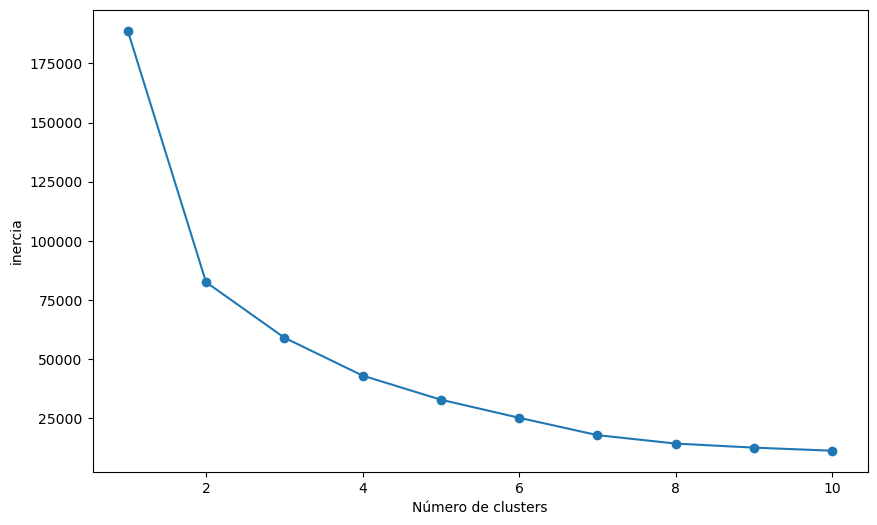

In [39]:
# achando o número ideal de clusters

inercia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(df_normalizado)
    inercia.append(kmeans.inertia_)


plt.figure(figsize=(10,6))
plt.plot(range(1,11), inercia, marker='o', linestyle='-')
plt.xlabel('Número de clusters')
plt.ylabel('inercia')
plt.savefig('cotovelo')
plt.show()

In [40]:
N_cluster = 3

KMeans_final = KMeans(n_clusters=N_cluster, init='k-means++', n_init=10, random_state=42)
cluster_labels = KMeans_final.fit_predict(df_normalizado)

# adicionando os dados em um dataframe apos a clusterizacao
df_classificado = pd.DataFrame(df_normalizado)
df_classificado['CLUSTER'] = cluster_labels

df_classificado.rename(columns={
    0:"PORT_DOADA",
    1:"PORT_RECEBIDA",
    2:"SERVICO",
    3:"PRESTADORA",
    4:"UF"}, inplace=True)
display(df_classificado.head())

,PORT_DOADA,PORT_RECEBIDA,SERVICO,PRESTADORA,UF,CLUSTER
0,-0.997861,-0.999438,-1.0,0.705,-0.692308,1
1,-0.993768,-0.992599,-1.0,0.210,-1.000000,1
2,-0.979443,-0.994566,-1.0,0.485,0.307692,1
3,-0.997023,-0.996627,1.0,-0.060,0.307692,2
4,-0.994326,-1.000000,1.0,0.210,0.923077,0


In [41]:
# agrupando pelos clusters
agregacoes = {
    'PORT_DOADA': 'mean',
    'PORT_RECEBIDA': 'mean',
    'SERVICO': lambda x: x.mode()[0],
    'PRESTADORA': lambda x: x.mode()[0],
    'UF': lambda x: x.mode()[0]
}
# Aplica o groupby e as agregações
resumo_clusters = df_classificado.groupby('CLUSTER').agg(agregacoes)

# Opcional: Renomear as colunas para clareza
resumo_clusters.rename(columns={
    'PORT_DOADA': 'MEDIA_PORT_DOADA',
    'PORT_RECEBIDA': 'MEDIA_PORT_RECEBIDA',
    'SERVICO': 'MODA_SERVICO',
    'PRESTADORA': 'MODA_PRESTADORA',
    'UF': 'MODA_UF'
}, inplace=True)

print(resumo_clusters)

         MEDIA_PORT_DOADA  MEDIA_PORT_RECEBIDA  MODA_SERVICO  MODA_PRESTADORA  \
CLUSTER                                                                         
0               -0.992353            -0.992422           1.0            0.705   
1               -0.971436            -0.971012          -1.0           -0.670   
2               -0.993105            -0.989532           1.0           -0.670   

          MODA_UF  
CLUSTER            
0        0.923077  
1        0.923077  
2        0.923077  


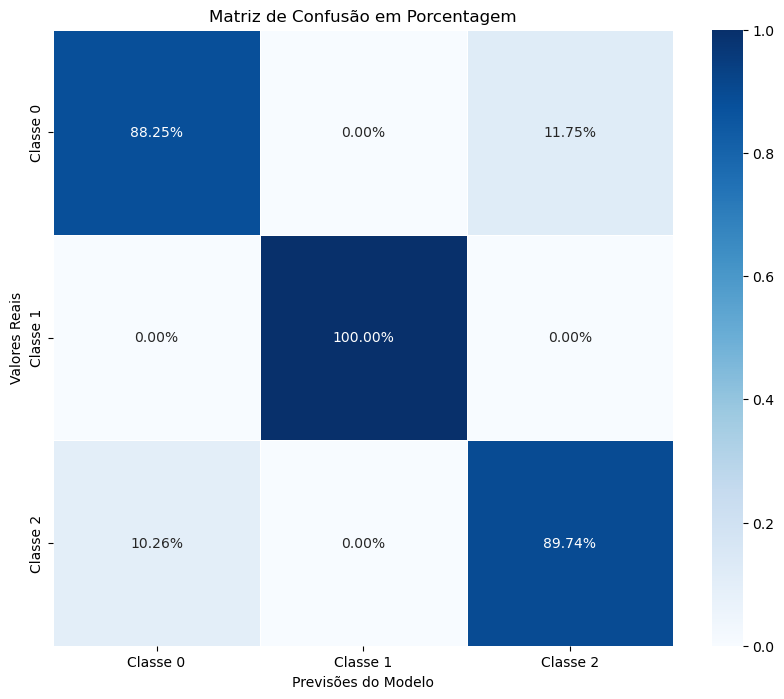

In [44]:
# criando feature e target
X = df_classificado.drop(['CLUSTER'], axis=1)
y = df_classificado['CLUSTER']

# divisao entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convertendo colunas de classificacao para tipo category para melhor adequacao ao xgbclassifier
categorical_cols = ['SERVICO', 'UF', 'PRESTADORA']
for col in categorical_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')


model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

# treinamento do modelo
model.fit(X_train, y_train)

# previsoes
y_pred = model.predict(X_test)


class_labels = ['Classe 0','Classe 1', 'Classe 2']

# Crie a matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred)

# Calcule a porcentagem por linha
matriz_porcentagem = matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis]

# Crie o DataFrame para a visualização
df_porcentagem = pd.DataFrame(matriz_porcentagem,
                              index=class_labels,
                              columns=class_labels)

# --- 4. Criando o Gráfico de Calor ---
plt.figure(figsize=(10, 8))
sns.heatmap(df_porcentagem, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues',
            linewidths=.5,
            cbar=True)

plt.title('Matriz de Confusão em Porcentagem')
plt.ylabel('Valores Reais')
plt.xlabel('Previsões do Modelo')
plt.savefig('confusion_matrix.png')
plt.show()